In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import SelectFpr, f_classif
from sklearn import metrics
from sklearn.externals import joblib

from nltk import word_tokenize, sent_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from keras.layers import Input, MaxPooling1D, Flatten, Dense, Dropout, Activation, Convolution1D, Embedding, concatenate, merge
from keras.layers import GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Merge

from collections import Counter, defaultdict
import os
import re
import pprint
import matplotlib.pyplot as plt
from tabulate import tabulate
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
import pickle

plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
sleep_tweets_df = pd.read_csv('/media/data/sleep_labeled_dec22.csv')
n_samples = len(sleep_tweets_df)
n_positives = sum(sleep_tweets_df.first_person_sleep_problem == True)
print("[Sleep] True labels: %d/%d (%.3f%%)" % (n_positives, n_samples, n_positives / n_samples * 100.0))

sb_tweets_df = pd.read_csv('/media/data/sedentary_labeled_jan11.csv')
n_samples = len(sb_tweets_df)
n_positives = sum(sb_tweets_df.first_person_sedentary_behavior == True)
print("[Sedentary Behavior] True labels: %d/%d (%.3f%%)" % (n_positives, n_samples, n_positives / n_samples * 100.0))

pa_tweets_df = pd.read_csv('/media/data/pa_labeled_dec22.csv')
n_samples = len(pa_tweets_df)
n_positives = sum(pa_tweets_df.first_person_physical_activity == True)
print("[Physical Activity] True labels: %d/%d (%.3f%%)" % (n_positives, n_samples, n_positives / n_samples * 100.0))
pa_tweets_df.head()

[Sleep] True labels: 93/1204 (7.724%)
[Sedentary Behavior] True labels: 97/2403 (4.037%)
[Physical Activity] True labels: 91/1810 (5.028%)


,text,hashtags,placename,first_person_physical_activity,Unnamed: 4,1794,90,1701
0,1 month out from my surgery as of yesterday &a...,NaN,NaN,1,NaN,NaN,NaN,NaN
1,Morning. Here\\u2019s your windswept skies Tor...,NaN,"Toronto, Ontario",0,NaN,NaN,NaN,NaN
2,Someone talk me out of the Barrelman Bike/Run ...,NaN,"Toronto, Ontario",0,NaN,NaN,NaN,NaN
3,Successfully surprised Bri (and 10 other dance...,missdancesomuch,"Kingston, Ontario",0,NaN,NaN,NaN,NaN
4,A train with no tracks? The world's first smar...,NaN,"Fort Saskatchewan, Alberta",0,NaN,NaN,NaN,NaN


# Preprocessing

* Removing urls, usernames, special characters and numbers
* WordNet Lemmatizer + nltk word tokenizer
* Removing stop words

In [3]:
class TwitterCleaner:
    def iterate(self):
        for cleanup_method in [self.remove_b,
                               self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def tokenize(tweets):
        tweets.loc[:, 'text'] = tweets_df.text.apply(lambda x: ' '.join([wnl.lemmatize(t) for t in word_tokenize(x)]))            
        return tweets
    
    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return self.remove_by_regex(tweets, re.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_b(self, tweets):
        return self.remove_by_regex(tweets, re.compile(r'(b\')|(b\")'))     
    
    def remove_special_chars(self, tweets):
        for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return self.remove_by_regex(tweets, re.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return self.remove_by_regex(tweets, re.compile(r"\s?[0-9]+\.?[0-9]*"))
    
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) for w in RegexpTokenizer(r'\w+').tokenize(t)]

def cleanup(df, cleaner):
    t = df
    for cleanup_method in cleaner.iterate():
        t = cleanup_method(t)
    return t

In [4]:
cleaner = TwitterCleaner()
sleep_tweets_df = cleanup(sleep_tweets_df, cleaner)
pa_tweets_df = cleanup(pa_tweets_df, cleaner)
sb_tweets_df = cleanup(sb_tweets_df, cleaner)

sleep_tweets_df['hashtags'] = sleep_tweets_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')
pa_tweets_df['hashtags'] = pa_tweets_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')
sb_tweets_df['hashtags'] = sb_tweets_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')

X_sleep = sleep_tweets_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)
y_sleep = sleep_tweets_df.first_person_sleep_problem

X_sb = sb_tweets_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)
y_sb = sb_tweets_df.first_person_sedentary_behavior

X_pa = pa_tweets_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)
y_pa = pa_tweets_df.first_person_physical_activity

In [377]:
full_sleep_df = pd.read_csv('/media/data/sleep_tweets_full.csv')
print(len(full_sleep_df))

cleaner = TwitterCleaner()
full_sleep_df = cleanup(full_sleep_df, cleaner)
full_sleep_df['hashtags'] = full_sleep_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')
X_fullsleep = full_sleep_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)

full_sleep_df.head()

full_pa_df = pd.read_csv('/media/data/pa_tweets_full.csv')
print(len(full_pa_df))

cleaner = TwitterCleaner()
full_pa_df = cleanup(full_pa_df, cleaner)
full_pa_df['hashtags'] = full_pa_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')
X_fullpa = full_pa_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)

full_pa_df.head()

full_sb_df = pd.read_csv('/media/data/sb_tweets_full.csv')
print(len(full_sb_df))

cleaner = TwitterCleaner()
full_sb_df = cleanup(full_sb_df, cleaner)
full_sb_df['hashtags'] = full_sb_df.hashtags.apply(lambda x: x if not pd.isnull(x) else '')
X_fullsb = full_sb_df[['text', 'hashtags']].apply(lambda x: ' '.join(x), axis=1)

full_sb_df.head()

3004


,text,hashtags,placename,first_person_sleep_problem,Unnamed: 4
0,Its still dark outside Im going back to bed I ...,MondayMotivation,"Brampton, Ontario",0.0,NaN
1,enjoy your bed I am just glad to see the sun o...,,"Toronto, Ontario",0.0,NaN
2,Back in first where I belong how goes the rest...,cflfantasy,"Corman Park No. 344, Saskatchewan",0.0,NaN
3,aww too bad but enjoy bed it is chilly out the...,,"Toronto, Ontario",0.0,NaN
4,Have you ever felt so tired that you worried t...,,"Hamilton, Ontario",0.0,NaN


In [394]:
def predict_tweet(x):
    y_pred_lr_tfidf = lr_tfidf.predict([x])
    y_prob_lr_tfidf = lr_tfidf.predict_proba([x])
    
    y_pred_xgb_tfidf = xgb_tfidf.predict([x])
    y_prob_xgb_tfidf = xgb_tfidf.predict_proba([x])
    
    seq = tokenizer.texts_to_sequences([x])
    X = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    
    y_prob_cnn = model.predict([X])
    y_pred_cnn = y_prob_cnn[0][0] > 0.50
    
    return pd.Series(dict(y_pred_lr_tfidf = int(y_pred_lr_tfidf[0]), 
                          y_prob_lr_tfidf = y_prob_lr_tfidf[0][1],
                          y_pred_xgb_tfidf = int(y_pred_xgb_tfidf[0]),
                          y_prob_xgb_tfidf = y_prob_xgb_tfidf[0][1],
                          y_pred_cnn = int(y_pred_cnn),
                          y_prob_cnn = y_prob_cnn[0][0]))

In [381]:
result = full_sleep_df.text.apply(predict_tweet)

pd.concat((full_sleep_df, result,), axis=1).loc[:, 
  ['text', 'first_person_sleep_problem',
   'y_pred_cnn', 'y_prob_cnn',
   'y_pred_lr_tfidf', 'y_prob_lr_tfidf',
    'y_pred_xgb_tfidf', 'y_prob_xgb_tfidf']
].to_csv('/media/data/sleep_tweets_classified.csv', index=False)

In [390]:
result = full_pa_df.text.apply(predict_tweet)

pd.concat((full_pa_df, result,), axis=1).loc[:, 
  ['text', 'first_person_physical_activity',
   'y_pred_cnn', 'y_prob_cnn',
   'y_pred_lr_tfidf', 'y_prob_lr_tfidf',
    'y_pred_xgb_tfidf', 'y_prob_xgb_tfidf']
].to_csv('/media/data/pa_tweets_classified.csv', index=False)

In [395]:
result = full_sb_df.text.apply(predict_tweet)

pd.concat((full_sb_df, result,), axis=1).loc[:, 
  ['text', 'first_person_sedentary_behavior',
   'y_pred_cnn', 'y_prob_cnn',
   'y_pred_lr_tfidf', 'y_prob_lr_tfidf',
    'y_pred_xgb_tfidf', 'y_prob_xgb_tfidf']
].to_csv('/media/data/sb_tweets_classified.csv', index=False)

In [13]:
xgb_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ("xgboost", XGBClassifier(n_estimators=200))])

lr_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ('logistic_regression', GridSearchCV(
                            LogisticRegression(penalty='l2', 
                                               random_state=42), 
                                               param_grid=params))])
lr_tfidf.fit(X_sleep, y_sleep)
xgb_tfidf.fit(X_sleep, y_sleep)
joblib.dump(lr_tfidf, 'model/lr_tfidf_sleep.pkl')
joblib.dump(xgb_tfidf, 'model/xgb_tfidf_sleep.pkl')

xgb_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ("xgboost", XGBClassifier(n_estimators=200))])

lr_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ('logistic_regression', GridSearchCV(
                            LogisticRegression(penalty='l2', 
                                               random_state=42), 
                                               param_grid=params))])

lr_tfidf.fit(X_pa, y_pa)
xgb_tfidf.fit(X_pa, y_pa)
joblib.dump(lr_tfidf, 'model/lr_tfidf_pa.pkl')
joblib.dump(xgb_tfidf, 'model/xgb_tfidf_pa.pkl')

xgb_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ("xgboost", XGBClassifier(n_estimators=200))])

lr_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ('logistic_regression', GridSearchCV(
                            LogisticRegression(penalty='l2', 
                                               random_state=42), 
                                               param_grid=params))])

lr_tfidf.fit(X_sb, y_sb)
xgb_tfidf.fit(X_sb, y_sb)
joblib.dump(lr_tfidf, 'model/lr_tfidf_sb.pkl')
joblib.dump(xgb_tfidf, 'model/xgb_tfidf_sb.pkl')

model = get_basic1dCNN()
sequences = tokenizer.texts_to_sequences(X_sleep)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
model.fit(X, y_sleep, epochs=10, batch_size=128)
model.save('model/cnn_sleep.h5')

model = get_basic1dCNN()
sequences = tokenizer.texts_to_sequences(X_pa)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
model.fit(X, y_pa, epochs=10, batch_size=128)
model.save('model/cnn_pa.h5')

model = get_basic1dCNN()
sequences = tokenizer.texts_to_sequences(X_sb)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
model.fit(X, y_sb, epochs=10, batch_size=128)
model.save('model/cnn_sb.h5')

['model/xgb_tfidf_sb.pkl']

# Model 1 (baseline)

TFIDF & Bag-of-words (CountVectorizer) features using multiple n-grams features combined with a various classifiers:

* [Extra trees](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
* Multinomial Naive Bayes
* Bernoulli Naive Bayes
* linear kernel SVM
* word2vec: using 100-dimensional glove word2vec embeddings
* XGBoost

The results are averaged out from 5-fold cross-validation

In [5]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

etree_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ("extra trees", ExtraTreesClassifier(n_estimators=200))    
        ])

xgb_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ("xgboost", XGBClassifier(n_estimators=200))    
        ])

lr_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=LemmaTokenizer(),
                                                   stop_words='english')),
            ('feature_selection', SelectFpr(f_classif)), # false positive rate test for feature selection
            ('logistic_regression', GridSearchCV(
                            LogisticRegression(penalty='l2', 
                                               random_state=42), 
                                               param_grid=params))
        ])

mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), 
                    ("multinomial nb", MultinomialNB())])

bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), 
                    ("bernoulli nb", BernoulliNB())])

mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x, 
                                                              ngram_range=(1,4),  
                                                              lowercase=False,
                                                              tokenizer=LemmaTokenizer(),
                                                              stop_words='english')), 
                          ("multinomial nb", MultinomialNB())])

bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x,
                                                               ngram_range=(1,4),  
                                                               lowercase=False,
                                                               tokenizer=LemmaTokenizer(),
                                                               stop_words='english')), 
                          ("bernoulli nb", BernoulliNB())])

svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), 
                ("linear svc", SVC(kernel="linear"))])

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x,
                                                           ngram_range=(1,4),  
                                                           lowercase=False,
                                                           tokenizer=LemmaTokenizer(),
                                                           stop_words='english')), 
                      ("linear svc", SVC(kernel="linear"))])

In [8]:
GLOVE_DIR = '/media/data/glove/glove.6B'

X = pd.concat((X_pa, X_sb, X_sleep), ignore_index=True)

w2v = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        w2v[word] = coefs

print('Found %s word vectors.' % len(w2v))

glove_small = {}
all_words = set(w for words in X for w in words.split(' '))
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

Found 400000 word vectors.


In [6]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X])
    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        #tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf = TfidfVectorizer(ngram_range=(1,4),  
                                lowercase=False,
                                tokenizer=LemmaTokenizer(),
                                stop_words='english')
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [9]:
xgb_w2v = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("xgb", XGBClassifier(n_estimators=200))])

xgb_w2v_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("xgb", XGBClassifier(n_estimators=200))])

etree_w2v = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [10]:
all_models = [
    ("TF-IDF features + Logistic regression", lr_tfidf),
    ("TF-IDF features + XGBoost", xgb_tfidf),
    ("TF-IDF features + Extra-trees", etree_tfidf), 
    ("Bag-of-words features + Multinomial Naive Bayes", mult_nb),
    ("TF-IDF features + Multinomial Naive Bayes", mult_nb_tfidf),
    ("Bag-of-words features + Bernoulli Naive Bayes", bern_nb),
    ("TF-IDF features + Bernoulli Naive Bayes", bern_nb_tfidf),
    ("Bag-of-words features + Linear SVC", svc),
    ("TF-IDF features + Linear SVC", svc_tfidf),
    ("Glove word-embeddings (averaged) + XGBoost", xgb_w2v),
    ("TF-IDF weighted Glove word-embeddings (averaged) + XGBoost", xgb_w2v_tfidf),    
    ("Glove word-embeddings (averaged) + Extra trees", etree_w2v),
    ("TF-IDF weighted Glove word-embeddings (averaged) + Extra trees", etree_w2v_tfidf)]

In [18]:
unsorted_scores_sleep = [(name, cross_val_score(model, X_sleep, y_sleep, cv=5, scoring='roc_auc', n_jobs=1).mean()) for name, model in all_models]
sleep_scores = sorted(unsorted_scores_sleep, key=lambda x: -x[1])

unsorted_scores_sb = [(name, cross_val_score(model, X_sb, y_sb, cv=5, scoring='roc_auc', n_jobs=1).mean()) for name, model in all_models]
sb_scores = sorted(unsorted_scores_sb, key=lambda x: -x[1])

unsorted_scores_pa = [(name, cross_val_score(model, X_pa, y_pa, cv=5, scoring='roc_auc', n_jobs=1).mean()) for name, model in all_models]
pa_scores = sorted(unsorted_scores_pa, key=lambda x: -x[1])

print (tabulate(sleep_scores, floatfmt=".4f", headers=("model (Sleep)", 'AUC score')))
print (tabulate(sb_scores, floatfmt=".4f", headers=("model (Sedentary Behavior)", 'AUC score')))
print (tabulate(pa_scores, floatfmt=".4f", headers=("model (Physical Activity)", 'AUC score')))

model (Sleep)                                                     AUC score
--------------------------------------------------------------  -----------
TF-IDF features + Logistic regression                                0.8499
TF-IDF features + XGBoost                                            0.8204
TF-IDF features + Extra-trees                                        0.7724
TF-IDF features + Bernoulli Naive Bayes                              0.7585
Bag-of-words features + Bernoulli Naive Bayes                        0.7585
Glove word-embeddings (averaged) + XGBoost                           0.7203
TF-IDF weighted Glove word-embeddings (averaged) + Extra trees       0.7053
Bag-of-words features + Multinomial Naive Bayes                      0.7046
TF-IDF weighted Glove word-embeddings (averaged) + XGBoost           0.7021
Glove word-embeddings (averaged) + Extra trees                       0.7017
TF-IDF features + Linear SVC                                         0.6811
TF-IDF featu

## Model 2 (Deep Learning)

Using pre-trained word embeddings (Glove) with a basic 1d convolutional neural network.

In [19]:
GLOVE_DIR = '/media/data/glove/glove.6B'

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

X = pd.concat((X_pa, X_sb, X_sleep), ignore_index=True)

tokenizer = Tokenizer(MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 13440 unique tokens.
Shape of data tensor: (5417, 1000)
Found 400000 word vectors.


In [119]:
def get_basic1dCNN():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False))

    model.add(Convolution1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Convolution1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Convolution1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(35))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

model = get_basic1dCNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         1344100   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 128)            0         
__________

In [23]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000

print("Sedentary Behavior")
sequences = tokenizer.texts_to_sequences(X_sb)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_sb, model, folds=5)
sb_scores.append(('CNN + Max pooling', np.mean(scores)))

print("Physical activity")
sequences = tokenizer.texts_to_sequences(X_pa)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_pa, model, folds=5)
pa_scores.append(('CNN + Max pooling', np.mean(scores)))

print("Sleep")
sequences = tokenizer.texts_to_sequences(X_sleep)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_sleep, model, folds=5)
sleep_scores.append(('CNN + Max pooling', np.mean(scores)))

Sedentary Behavior
482/482 [==============================] - 0s 146us/step

Fold 0 AUC score:  0.664935064935
481/481 [==============================] - 0s 82us/step

Fold 1 AUC score:  0.509761388286
480/480 [==============================] - 0s 64us/step

Fold 2 AUC score:  0.479506793013
480/480 [==============================] - 0s 78us/step

Fold 3 AUC score:  0.532595045096
480/480 [==============================] - 0s 63us/step

Fold 4 AUC score:  0.520607375271

Mean score: 0.54 (+/- 0.13)
Physical activity
363/363 [==============================] - 0s 89us/step

Fold 0 AUC score:  0.798959608323
362/362 [==============================] - 0s 102us/step

Fold 1 AUC score:  0.636789405685
362/362 [==============================] - 0s 68us/step

Fold 2 AUC score:  0.78084625323
362/362 [==============================] - 0s 86us/step

Fold 3 AUC score:  0.809431524548
361/361 [==============================] - 0s 83us/step

Fold 4 AUC score:  0.786848072562

Mean score: 0.76 (+/- 

## Deep learning (Deeper)

Let's try a deeper model + dropout 

In [24]:
embedding_length = 1000
EMBEDDING_DIM = 100

def get_CNN_model():
    graph_in = Input(shape=(embedding_length, EMBEDDING_DIM))
    convs = []
    for fsz in range(1, 4):
        conv = Convolution1D(filters=300, kernel_size=fsz, padding='valid', activation='relu')(graph_in)
        pool = MaxPooling1D(pool_size=2)(conv)
        flatten = Flatten()(pool)
        convs.append(flatten)

    out = Merge(mode='concat')(convs)
    graph = Model(inputs=graph_in, outputs=out)

    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False))

    model.add(graph)
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

model = get_CNN_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         1344100   
_________________________________________________________________
model_1 (Model)              (None, 449400)            180900    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               134820300 
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

/home/lmccrack/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [25]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000

print("Sedentary Behavior")
sequences = tokenizer.texts_to_sequences(X_sb)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_sb, model, folds=5)
sb_scores.append(('Deeper CNN + Max pooling + Dropout', np.mean(scores)))

print("Physical activity")
sequences = tokenizer.texts_to_sequences(X_pa)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_pa, model, folds=5)
pa_scores.append(('Deeper CNN + Max pooling + Dropout', np.mean(scores)))

print("Sleep")
sequences = tokenizer.texts_to_sequences(X_sleep)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
scores, conf_mat, fp_fn_dict = analyze_model(X, y_sleep, model, folds=5)
sleep_scores.append(('Deeper CNN + Max pooling + Dropout', np.mean(scores)))

Sedentary Behavior
482/482 [==============================] - 1s 2ms/step

Fold 0 AUC score:  0.635714285714
481/481 [==============================] - 1s 2ms/step

Fold 1 AUC score:  0.49295010846
480/480 [==============================] - 1s 2ms/step

Fold 2 AUC score:  0.432012786848
480/480 [==============================] - 1s 2ms/step

Fold 3 AUC score:  0.48590021692
480/480 [==============================] - 1s 2ms/step

Fold 4 AUC score:  0.560794611257

Mean score: 0.52 (+/- 0.14)
Physical activity
363/363 [==============================] - 1s 2ms/step

Fold 0 AUC score:  0.746787025704
362/362 [==============================] - 1s 2ms/step

Fold 1 AUC score:  0.652939276486
362/362 [==============================] - 1s 2ms/step

Fold 2 AUC score:  0.794896640827
362/362 [==============================] - 1s 2ms/step

Fold 3 AUC score:  0.757913436693
361/361 [==============================] - 1s 2ms/step

Fold 4 AUC score:  0.726271460965

Mean score: 0.74 (+/- 0.09)
Sleep
2

## Results

In [26]:
sleep_scores = sorted(sleep_scores, key=lambda x: -x[1])
sb_scores = sorted(sb_scores, key=lambda x: -x[1])
pa_scores = sorted(pa_scores, key=lambda x: -x[1])

print (tabulate(sleep_scores, floatfmt=".4f", headers=("model (Sleep)", 'AUC score')))
print (tabulate(sb_scores, floatfmt=".4f", headers=("model (Sedentary Behavior)", 'AUC score')))
print (tabulate(pa_scores, floatfmt=".4f", headers=("model (Physical Activity)", 'AUC score')))

model (Sleep)                                                     AUC score
--------------------------------------------------------------  -----------
TF-IDF features + Logistic regression                                0.8499
TF-IDF features + XGBoost                                            0.8204
CNN + Max pooling                                                    0.7801
TF-IDF features + Extra-trees                                        0.7724
TF-IDF features + Bernoulli Naive Bayes                              0.7585
Bag-of-words features + Bernoulli Naive Bayes                        0.7585
Deeper CNN + Max pooling + Dropout                                   0.7540
Glove word-embeddings (averaged) + XGBoost                           0.7203
TF-IDF weighted Glove word-embeddings (averaged) + Extra trees       0.7053
Bag-of-words features + Multinomial Naive Bayes                      0.7046
TF-IDF weighted Glove word-embeddings (averaged) + XGBoost           0.7021
Glove word-e

# Evaluation w/ 5-fold cross validation

In [96]:
from sklearn.base import clone

def class_report(conf_mat):
    tp, fp, fn, tn = conf_mat.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

def analyze_model(X, y, model=None, folds=5):
    ''' Run x-validation and return scores, averaged confusion matrix, and df with false positives and negatives '''
    if not model:
        return

    # Manual x-validation to accumulate actual
    cv_skf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=42)
    scores = []
    conf_mat = np.zeros((2, 2))      # Binary classification
    false_pos = set()
    false_neg = set()
    
    init_weights = model.get_weights()
    for idx, (train_i, val_i) in enumerate(cv_skf.split(X, y)):
        X_train, X_val = X[train_i], X[val_i]
        y_train, y_val = y[train_i], y[val_i]

        model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        y_pprobs = model.predict_proba(X_val)       # Predicted probabilities
        y_plabs = np.squeeze(model.predict(X_val))  # Predicted class labels

        scores.append(metrics.roc_auc_score(y_val, y_pprobs))        

        # Collect indices of false positive and negatives
        fp_i = np.where((y_plabs==1) & (y_val==0))[0]
        fn_i = np.where((y_plabs==0) & (y_val==1))[0]
        false_pos.update(val_i[fp_i])
        false_neg.update(val_i[fn_i])

        print("\nFold %d AUC score: " % idx, scores[-1])
        #print("Fold CM: \n", confusion)
        model.set_weights(init_weights)

    print("\nMean score: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
    #conf_mat /= folds
    #print("Mean CM: \n", conf_mat)
    #print("\nMean classification measures: \n")
    #print(class_report(conf_mat))
    
    return scores, conf_mat, {'fp': sorted(false_pos), 'fn': sorted(false_neg)}

def class_report(conf_mat):
    tp, fp, fn, tn = conf_mat.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

def plot_auc_roc(X, y, model=None, folds=5):
    ''' Run x-validation and return scores, averaged confusion matrix, and df with false positives and negatives '''
    if not model:
        return

    name, model = model
    print(model)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Manual x-validation to accumulate actual
    cv_skf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=42)
    scores = []
    conf_mat = np.zeros((2, 2))      # Binary classification
    false_pos = set()
    false_neg = set()
    
    if 'CNN' in name:
        init_weights = model.get_weights()
        sequences = tokenizer.texts_to_sequences(X)
        X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)        
    
    for idx, (train_i, val_i) in enumerate(cv_skf.split(X, y)):
        X_train, X_val = X[train_i], X[val_i]
        y_train, y_val = y[train_i], y[val_i]
    
        if 'CNN' in name:
            model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        else:
            model.fit(X_train, y_train)
            
        y_pprobs = model.predict_proba(X_val)       # Predicted probabilities
        y_plabs = np.squeeze(model.predict(X_val))  # Predicted class labels

        if not 'CNN' in name:
            y_pprobs = y_pprobs[:, 1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pprobs)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        scores.append(metrics.roc_auc_score(y_val, y_pprobs))        

        # Collect indices of false positive and negatives
        fp_i = np.where((y_plabs==1) & (y_val==0))[0]
        fn_i = np.where((y_plabs==0) & (y_val==1))[0]
        false_pos.update(val_i[fp_i])
        false_neg.update(val_i[fn_i])

        print("\nFold %d AUC score: " % idx, scores[-1])
        
        if 'CNN' in name:
            model.set_weights(init_weights)
        else:
            model = clone(model)
            
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 
             label=r'%s (Mean AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),
             lw=2, alpha=.8)
    
    print("\nMean score: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))    
    return scores, conf_mat, {'fp': sorted(false_pos), 'fn': sorted(false_neg)}

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))])

Fold 0 AUC score:  0.851309889072

Fold 1 AUC score:  0.876126126126

Fold 2 AUC score:  0.84329065908

Fold 3 AUC score:  0.814064064064

Fold 4 AUC score:  0.86473973974

Mean score: 0.85 (+/- 0.04)
Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...
       reg_alpha=0, reg_lambda=1, s

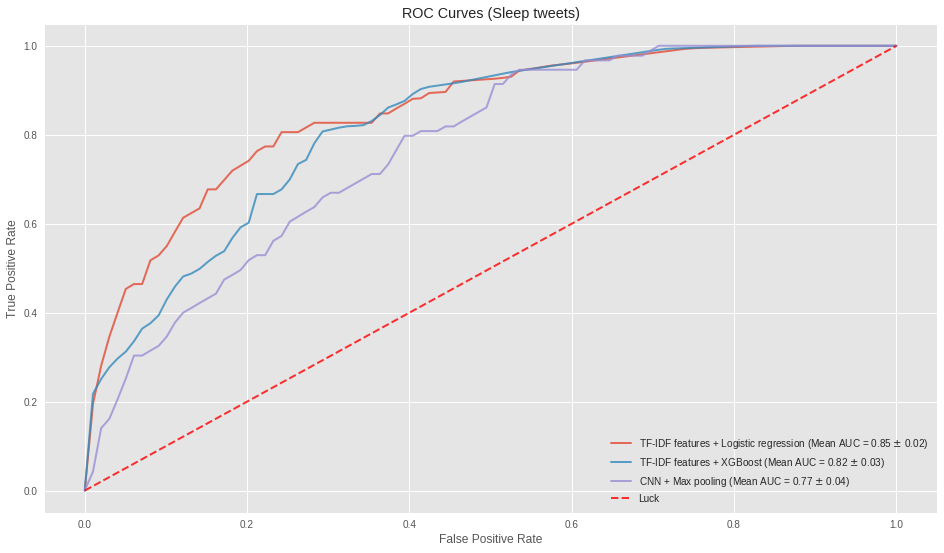

In [97]:
all_models = [
   ("TF-IDF features + Logistic regression", lr_tfidf),
   ("TF-IDF features + XGBoost", xgb_tfidf),
    ("CNN + Max pooling", model)]

plt.figure(figsize=(16, 9))

for m in all_models:
    plot_auc_roc(X_sleep, y_sleep, m, folds=5)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Sleep tweets)')
plt.legend(loc="lower right")
plt.show()

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))])

Fold 0 AUC score:  0.631655446756

Fold 1 AUC score:  0.732315891473

Fold 2 AUC score:  0.587370801034

Fold 3 AUC score:  0.661660206718

Fold 4 AUC score:  0.636864269517

Mean score: 0.65 (+/- 0.10)
Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...
       reg_alpha=0, reg_lambda=1,

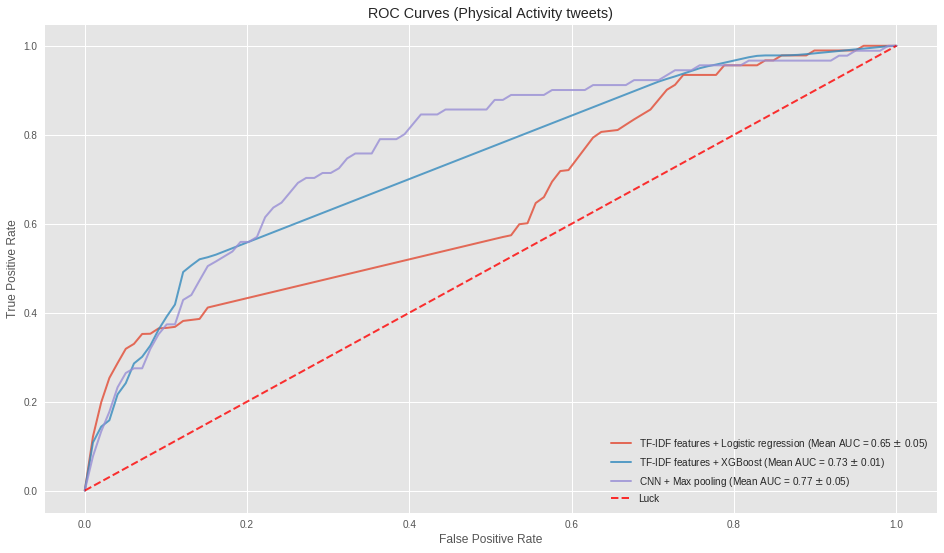

In [98]:
all_models = [
   ("TF-IDF features + Logistic regression", lr_tfidf),
   ("TF-IDF features + XGBoost", xgb_tfidf),
    ("CNN + Max pooling", model)]

plt.figure(figsize=(16, 9))

for m in all_models:
    plot_auc_roc(X_pa, y_pa, m, folds=5)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Physical Activity tweets)')
plt.legend(loc="lower right")
plt.show()

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))])

Fold 0 AUC score:  0.417803030303

Fold 1 AUC score:  0.408568329718

Fold 2 AUC score:  0.466491608631

Fold 3 AUC score:  0.51832400959

Fold 4 AUC score:  0.461354035849

Mean score: 0.45 (+/- 0.08)
Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smoo...
       reg_alpha=0, reg_lambda=1, 

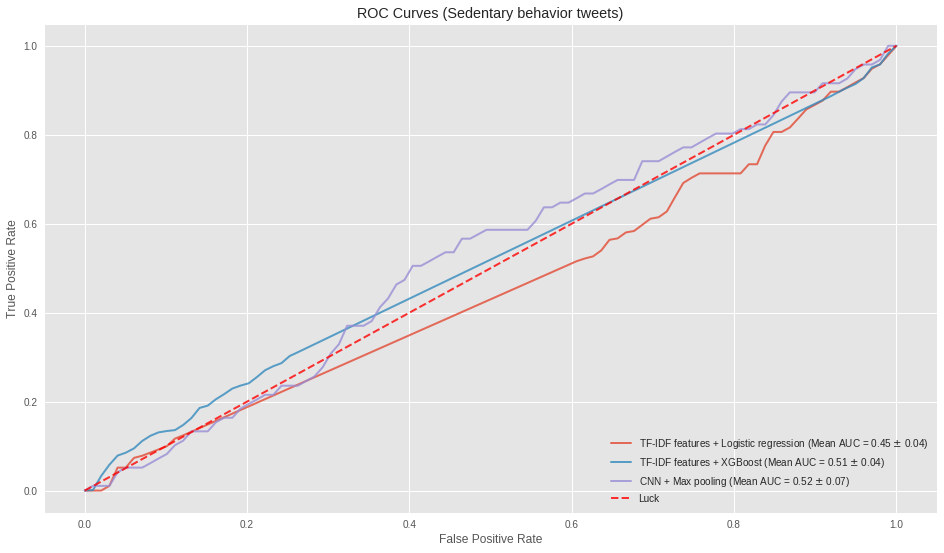

In [99]:
all_models = [
   ("TF-IDF features + Logistic regression", lr_tfidf),
   ("TF-IDF features + XGBoost", xgb_tfidf),
    ("CNN + Max pooling", model)]

plt.figure(figsize=(16, 9))

for m in all_models:
    plot_auc_roc(X_sb, y_sb, m, folds=5)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Sedentary behavior tweets)')
plt.legend(loc="lower right")
plt.show()

In [178]:
print('Classifying sleep tweets:')
scores, conf_mat, fp_fn_dict = analyze_model(X_sleep, y_sleep, model, folds=5)

print('Classifying sedentary behavior tweets:')
scores, conf_mat, fp_fn_dict = analyze_model(X_sb, y_sb, model, folds=5)

print('Classifying physical activity tweets:')
scores, conf_mat, fp_fn_dict = analyze_model(X_pa, y_pa, model, folds=5)

Classifying sleep tweets:
Fold 0 AUC score:  0.647037998584
Fold CM: 
 [[222   1]
 [ 17   2]]
Fold 1 AUC score:  0.85289236605
Fold CM: 
 [[218   4]
 [ 19   0]]
Fold 2 AUC score:  0.773707918445
Fold CM: 
 [[217   5]
 [ 18   1]]
Fold 3 AUC score:  0.824324324324
Fold CM: 
 [[220   2]
 [ 18   0]]
Fold 4 AUC score:  0.83470970971
Fold CM: 
 [[222   0]
 [ 17   1]]

Mean score: 0.79 (+/- 0.15)
Mean CM: 
 [[ 219.8    2.4]
 [  17.8    0.8]]

Mean classification measures: 

{'precision': 0.98919891989198916, 'specificity': 0.25, 'accuracy': 0.91611295681063121, 'f1score': 0.95606785558938667, 'sensitivity': 0.92508417508417506}
Classifying sedentary behavior tweets:
Fold 0 AUC score:  0.55125
Fold CM: 
 [[240   0]
 [ 15   0]]
Fold 1 AUC score:  0.497083333333
Fold CM: 
 [[240   0]
 [ 15   0]]
Fold 2 AUC score:  0.500446428571
Fold CM: 
 [[240   0]
 [ 14   0]]
Fold 3 AUC score:  0.664823670054
Fold CM: 
 [[239   0]
 [ 14   0]]
Fold 4 AUC score:  0.554841601913
Fold CM: 
 [[237   2]
 [ 14   0]]

# Analyzing tf-idf results

Inspection of the most important words/n-grams in the dataset, by category

In [37]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(16, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

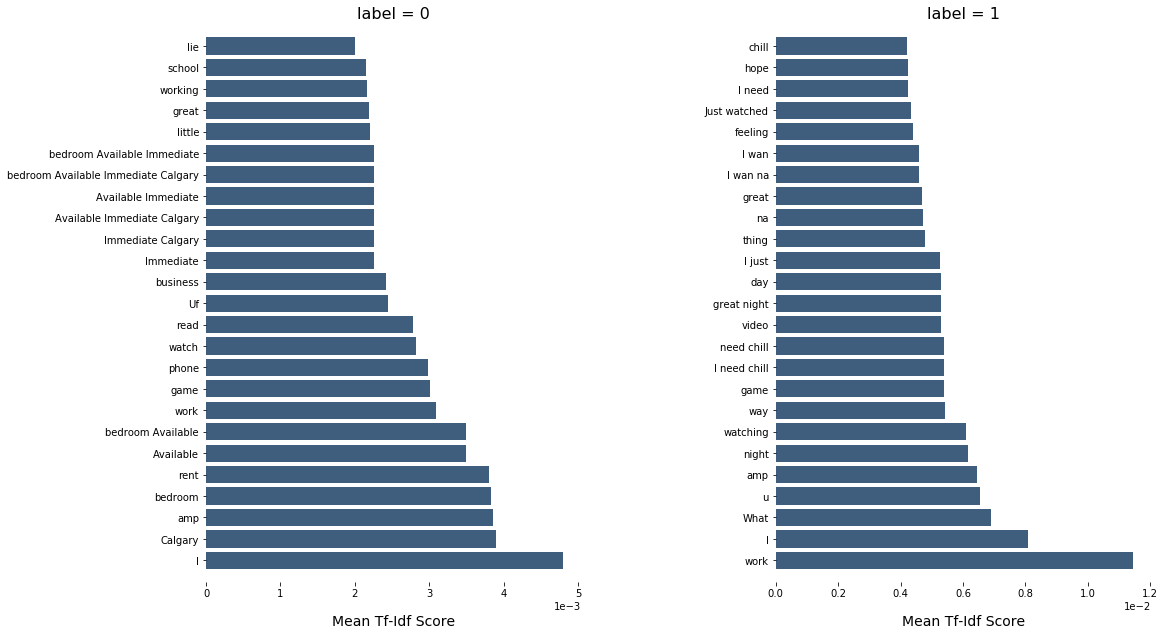

In [40]:
vectorizer = TfidfVectorizer(ngram_range=(1,4),  
                             lowercase=False,
                             tokenizer=LemmaTokenizer(),
                             stop_words='english')

X = vectorizer.fit_transform(X_sb)

features = vectorizer.get_feature_names()
tfidf_df= top_feats_by_class(X, y_sb, features)

plot_tfidf_classfeats_h(tfidf_df)